# Work done by pair of students

- Nico Sharei (nsharei)
- Artem Bisliouk (abisliou)

# Deep Learning: Assignment 2

In [1]:
# Define imports & defaults
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# import helper functions
import os
import sys

sys.path.append(os.getcwd())
from a02helper import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)  # ensure reproducibility
np.random.seed(0)
MAX_SEQ_LEN = 200
BATCH_SIZE = 32

## Task 1: Datasets

In [2]:
import string
from torchtext.data import get_tokenizer

class ReviewsDataset(Dataset):
    def __init__(
        self,
        reviews_file="data/reviews_small.txt",
        labels_file="data/labels_small.txt",
        use_vocab=False,
    ):
        """
        A dataset of movie reviews and their labels.

        Args:
            reviews_file: the reviews file
            labels_file:  the labels file
            use_vocab: if True, yield reviews in a numerical representation
        """
        # Load data from filesystem
        with open(reviews_file) as f:
            raw_reviews = f.readlines()

        with open(labels_file) as f:
            raw_labels = f.readlines()

        # Preprocessing and store (in memory)
        self._reviews = self._preprocess_reviews(raw_reviews)
        self._labels = self._preprocess_labels(raw_labels)

        # Build vocabulary
        self.vocab = None
        if use_vocab:
            from torchtext.vocab import build_vocab_from_iterator

            self.vocab = build_vocab_from_iterator(
                self._reviews, specials=["<pad>"]  # will get token id 0
            )

    def __len__(self):
        """Returns the length of the dataset."""
        # YOUR CODE HERE
        return len(self._reviews)


    def __getitem__(self, idx):
        """
        Returns a tuple of a preprocessed review and the corresponding label. If the
        vocabulary is enabled, returns a numerical representation of the review.

        Args:
            idx: a single index
        Returns: a (review, label) tuple
        """
        # YOUR CODE HERE
        review, label = self._reviews[idx], self._labels[idx]
    
        # If vocabulary is enabled, convert review to numerical representation
        if self.vocab is not None:
            review = [self.vocab[token] for token in review]

        return review, label



    def tokenize_review(self, review):
        tokenizer = get_tokenizer("basic_english")
        return tokenizer(review)
    
    def _preprocess_reviews(self, raw_reviews):
        """
        Applies two kinds of preprocessing:

        (i) Apply the "basic_english" tokenizer from the torchtext library to
        transform every review into a list of normalized tokens (cf.
        https://pytorch.org/text/stable/data_utils.html#get-tokenizer).


        (ii) Remove punctuation (cf.
        https://docs.python.org/3/library/string.html#string.punctuation).


        Returns: list of tokenized reviews
        """
        # YOUR CODE HERE

        tokenized_reviews = list(map(self.tokenize_review, raw_reviews))
        cleaned_reviews = [[token for token in review if token not in string.punctuation] for review in tokenized_reviews]

        return cleaned_reviews


    def _preprocess_labels(self, raw_labels):
        """
        Transform raw labels into integers, where 1="positive" and 0 otherwise.

        Returns: list of labels
        """
        # YOUR CODE HERE
        preprocessed_labels = [1 if label.strip() == 'positive' else 0 for label in raw_labels]

        return preprocessed_labels
        # Hint: You can remove leading and trailing whitespace from the raw labels using
        # the strip() method.

/opt/homebrew/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
# Test your code (without vocabulary).
dataset = ReviewsDataset()
print(dataset[0])

# Should yield:
# (['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', ... ], 1)

(['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', 'such', 'as', 'teachers', 'my', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', 'high', 's', 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', 'teachers', 'the', 'scramble', 'to', 'survive', 'financially', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', 'pomp', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', 'i', 'immediately', 'recalled', 'at', 'high', 'a', 'classic', 'line', 'inspector', 'i', 'm', 'here', 'to', 'sack', 'one', 'of', 'your', 'teachers', 'student', 'welcome', 'to', 'brom

In [4]:
# Test your code (with vocabulary).
dataset = ReviewsDataset(use_vocab=True)
print(dataset[0])

# Should yield:
# ([10661, 307, 6, 3, 1177, 202, 8,  ... ], 1)

([10661, 307, 6, 3, 1177, 202, 8, 2248, 33, 1, 168, 56, 15, 49, 85, 8902, 43, 422, 122, 140, 15, 3234, 59, 144, 9, 1, 5504, 6267, 454, 72, 5, 260, 12, 10661, 307, 13, 2060, 6, 73, 2780, 5, 692, 76, 6, 3234, 1, 29527, 5, 1730, 7117, 1, 6161, 1726, 36, 52, 68, 212, 143, 63, 1409, 3234, 17974, 1, 28056, 4, 1, 221, 758, 31, 2748, 72, 4, 1, 6311, 10, 731, 2, 63, 1726, 54, 10, 208, 1, 321, 9, 64, 3, 1601, 4042, 743, 5, 2853, 187, 1, 422, 10, 1254, 10116, 33, 307, 3, 380, 322, 6162, 10, 135, 136, 5, 10172, 30, 4, 134, 3234, 1601, 2545, 5, 10661, 307, 10, 529, 12, 113, 1841, 4, 59, 676, 103, 12, 10661, 307, 6, 227, 4163, 48, 3, 2201, 12, 8, 231, 21], 1)


/opt/homebrew/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/homebrew/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Task 2: Data Loaders

In [5]:
# Split dataset into training, validation, and test subsets
dataset = ReviewsDataset(use_vocab=True)
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(123)
)

### Task 2a

In [6]:
# Example usage of a data loader
dataloader = DataLoader(
    val_set,  # a dataset
    1,  # desired batch size
    False,  # whether to randomly shuffle the dataset
    num_workers=0,  # number of workers that construct batches in parallel
)

In [7]:
# Let's print the first batch
batch = next(iter(dataloader))
print(batch)

# [[tensor([11]), tensor([6]), tensor([1]), ...], tensor([0])]

[[tensor([11]), tensor([6]), tensor([1]), tensor([1037]), tensor([6578]), tensor([4]), tensor([10]), tensor([89]), tensor([120]), tensor([48]), tensor([163]), tensor([47]), tensor([6]), tensor([27]), tensor([342]), tensor([4]), tensor([2228]), tensor([140]), tensor([3]), tensor([186]), tensor([1466]), tensor([1]), tensor([771]), tensor([26]), tensor([78]), tensor([1459]), tensor([200]), tensor([1101]), tensor([1]), tensor([66]), tensor([26]), tensor([78]), tensor([5199]), tensor([5]), tensor([2288]), tensor([1]), tensor([7861]), tensor([6591]), tensor([2]), tensor([83]), tensor([2446]), tensor([25]), tensor([1]), tensor([182]), tensor([2756]), tensor([2520]), tensor([34]), tensor([1]), tensor([145]), tensor([8]), tensor([13]), tensor([39]), tensor([290]), tensor([25]), tensor([252]), tensor([14480]), tensor([32]), tensor([52]), tensor([497]), tensor([9]), tensor([223]), tensor([1]), tensor([3254]), tensor([25]), tensor([937]), tensor([2]), tensor([153]), tensor([568]), tensor([5]), ten

### Task 2b

In [8]:
from torch.nn.utils.rnn import pad_sequence

def review_collate_fn(raw_batch):
    """Prepare batches of reviews from a review dataset.

    Args:
        raw_batch: collection of (review, label)-tuples from a ReviewDataset

    Returns: a tuple (review x token id tensor, label tensor) of sizes
    batch_size*MAX_SEQ_LEN and batch_size, respectively.

    """

    reviews = [item[0] for item in raw_batch]
    labels = [item[1] for item in raw_batch]

    cropped_reviews = [review[:MAX_SEQ_LEN] for review in reviews]


    padded_reviews = pad_sequence([torch.tensor(review) for review in cropped_reviews], batch_first=True, padding_value=0)

    label_tensor = torch.tensor(labels)

    return padded_reviews, label_tensor

In [9]:
# Test your function
review_collate_fn([([1, 2, 3], 1), (torch.arange(MAX_SEQ_LEN * 2) + 1, 0)])

# Should yield:
# (tensor([[  1,   2,   3,   0,   0,  ..., 0 ],
#          [  1,   2,   3,   4,   5, ..., 200 ]]),
#  tensor([1, 0]))

/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_12712/2946447728.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_reviews = pad_sequence([torch.tensor(review) for review in cropped_reviews], batch_first=True, padding_value=0)


(tensor([[  1,   2,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0, 

In [10]:
# Create the data loaders (with shuffling for training data -> randomization)
train_loader = DataLoader(train_set, BATCH_SIZE, True, collate_fn=review_collate_fn)
val_loader = DataLoader(val_set, BATCH_SIZE, False, collate_fn=review_collate_fn)
test_loader = DataLoader(test_set, BATCH_SIZE, False, collate_fn=review_collate_fn)

In [11]:
# Let's print the first batch
batch = next(iter(val_loader))
print(batch)


# (tensor([[   11,     6,     1,  ...,     0,     0,     0],
#         [   11,   170,  2220,  ...,     0,     0,     0],
#         [   48,     3, 30376,  ...,     0,     0,     0],
#         ...,
#         [  176,    56,    10,  ...,     0,     0,     0],
#         [  239,   534,  1404,  ...,    44,   120,     1],
#         [ 2954, 15576,     6,  ...,  2678,    65,     1]]),
#  tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
#         0, 0, 0, 1, 1, 1, 0, 0]))

(tensor([[   11,     6,     1,  ...,     0,     0,     0],
        [   11,   170,  2220,  ...,     0,     0,     0],
        [   48,     3, 30376,  ...,     0,     0,     0],
        ...,
        [  176,    56,    10,  ...,     0,     0,     0],
        [  239,   534,  1404,  ...,    44,   120,     1],
        [ 2954, 15576,     6,  ...,  2678,    65,     1]]), tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0]))


## Task 3: Recurrent Neural Networks

In [12]:
class SimpleLSTM(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, num_layers=1, cell_dropout=0.0
    ):
        """
        Initializes the model by setting up the layers.

        Args:
            vocab_size: number of unique words in the reviews
            embedding_dim: size of the embeddings
            hidden_dim: dimension of the LSTM output
            num_layers: number of LSTM layers
            cell_dropout: dropout applied between the LSTM layers
                          (provide to LSTM constructor as dropout argument)
        """
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # YOUR CODE HERE
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=num_layers, dropout=cell_dropout, batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        """
        Performs a forward pass of the model on some input and hidden state.

        Parameters
        ----------
        x: batch as a (batch_size, sequence_length) tensor

        Returns
        -------
        Probability of positive class and the last output of the LSTM.
        """
        # init hidden layer, which is needed for the LSTM
        hidden = self.init_hidden(len(x))

        # YOUR CODE HERE

        # Embedding layer
        embedded = self.embedding(x)
        
        # LSTM layer
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Take the last output of the LSTM
        last_output = lstm_out[:, -1, :]

        # Linear layer
        logits = self.fc(last_output)

        # Sigmoid activation
        prob = self.sigmoid(logits)

        return prob, last_output

    def init_hidden(self, batch_size):
        """Initialize hidden states.

        Returns a tuple of two num_layers x batch_size x hidden_dim tensors (one for
        initial cell states, one for initial hidden states) consisting of all zeros.
        """

        # YOUR CODE HERE
        # Note: ensure that the returned tensors are located on DEVICE.
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(DEVICE),
            weight.new(self.num_layers, batch_size, self.hidden_dim).zero_().to(DEVICE)
        )
        return hidden


# Test constructor
model = SimpleLSTM(50, 10, 32, 2, 0.1).to(DEVICE)
print(model)

# Should give:
# SimpleLSTM(
#   (embedding): Embedding(50, 10)
#   (lstm): LSTM(10, 32, num_layers=2, batch_first=True, dropout=0.1)
#   (fc): Linear(in_features=32, out_features=1, bias=True)
#   (sigmoid): Sigmoid()
# )

SimpleLSTM(
  (embedding): Embedding(50, 10)
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [13]:
# Test forward pass
model = SimpleLSTM(50, 10, 32, 2).to(DEVICE)
dummy_data = torch.arange(30, dtype=torch.int, device=DEVICE).reshape(3, 10)

# fix model parameters
for key in model.state_dict():
    model.state_dict()[key][:] = 0.1
probs, states = model(dummy_data)
print(probs)
print(states)


# tensor([[0.9643],
#         [0.9643],
#         [0.9643]], device='cuda:0 or cpu', grad_fn=<SigmoidBackward0>)
# tensor([[0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
#         [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
#         [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
#          0.9985, 0.9985, 0.9985, 0.9985, 0.9985]], device='cuda:0 or cpu',
#        grad_fn=<SliceBackward0>)

tensor([[0.9643],
        [0.9643],
        [0.9643]], grad_fn=<SigmoidBackward0>)
tensor([[0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
        [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985],
        [0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985, 0.9985,
         0.9985, 0.9985, 0.9985, 0.9985, 0.9985]], grad_fn=<SliceBackward0>)


### Task 3d

In [14]:
@torch.no_grad()  # Disables autograd for this function
def reviews_eval(
    model, eval_loader, label="val", loss_fn=torch.nn.functional.binary_cross_entropy
):
    model.to(DEVICE)
    model.eval()  # sets model to evaluation mode (e.g., relevant for dropout)

    total_correct = total_loss = 0
    for reviews, labels in eval_loader:
        reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

        # Forward pass: Compute the model's output, reshape it to a vector, and
        # then run the provided loss function.
        # YOUR CODE HERE

        # Receive model output (probabilities)
        output, _ = model(reviews)
        output = output.view(-1)

        # Compute loss
        loss = loss_fn(output, labels.float())

        # Eval stats: Add loss to total_loss and number of correct predictions to
        # total_correct.
        # YOUR CODE HERE

        # Add loss to total_loss
        total_loss += loss.item()

        # Add number of correct predictions to total_correct
        total_correct += ((output > 0.5) == labels).sum().item()

    print(
        f"            "
        f"{label} accuracy: {total_correct / len(eval_loader.dataset):.4f}\t"
        f"{label} loss: {total_loss / len(eval_loader):.4f}"
    )

In [15]:
# Test your implementation
model = SimpleLSTM(len(dataset.vocab), 10, 10, 1, 0).to(DEVICE)
reviews_eval(model, val_loader)

# Should yield with different but similar numbers:
#             val accuracy: 0.5100	val loss: 0.6928

            val accuracy: 0.5375	val loss: 0.6925


### Task 3e

In [16]:
def reviews_train(
    model,
    train_loader,
    val_loader,
    lr=0.01,
    epochs=3,
    max_norm=5,
    loss_fn=torch.nn.functional.binary_cross_entropy,
):
    """
    Train a network on the review data

    Args:
        model: Initialized model
        train_loader: Dataloader for the training data
        val_loader: Dataloader for the validation data
        lr: learning rate
        epochs: number of epochs
        max_norm: max norm of gradients for gradient clipping
        loss_fn: Loss function
    """
    # Send the model's parameters to your accelerator (cuda or cpu)
    model = model.to(DEVICE)

    # Define optimizer for the parameters which require gradients (cf. Task 5)
    optimizer = torch.optim.Adam(
        [param for param in model.parameters() if param.requires_grad], lr=lr
    )

    # Let's go
    for epoch in range(epochs):
        total_correct = total_loss = 0
        for reviews, labels in train_loader:
            model.train()

            # Send batch to your accelerator
            reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

            # Forward pass: Compute the model's output, reshape it to a vector, and then
            # run the provided loss function.
            output, _ = model(reviews)
            output = output.view(-1)
            loss = loss_fn(output, labels.float())

            # Backward pass:
            # (i)   Compute the gradients wrt. the loss
            loss.backward()
            # (ii)  Clip the gradients using
            # https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html to max_norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            # (iii) Run the optimizer
            optimizer.step()
            # (iv)  Clear all accumulated gradients
            optimizer.zero_grad()

            # Compute epoch statistics:
            # (i)  Add the loss of this batch to the total_loss
            total_loss += loss.item()
            # (ii) Add the number of correct predictions (max prob) to total_correct
            total_correct += ((output > 0.5) == labels).sum().item()

        print(
            f"Epoch {epoch + 1:2}\t"
            f"train accuracy: {total_correct / len(train_loader.dataset):.4f}\t"
            f"train loss: {total_loss / len(train_loader):.4f}"
        )

        # now validate
        reviews_eval(model, val_loader, loss_fn=loss_fn)

In [17]:
# Test your implementation
model = SimpleLSTM(len(dataset.vocab), 10, 10, 1).to(DEVICE)
reviews_train(model, train_loader, val_loader, epochs=5)

# Should yield something like (note: numbers have high variance over runs):
# Epoch  1	train accuracy: 0.4994	train loss: 0.6953
#             val accuracy: 0.4875	val loss: 0.6922
# Epoch  2	train accuracy: 0.5319	train loss: 0.6885
#             val accuracy: 0.5275	val loss: 0.6861
# Epoch  3	train accuracy: 0.6059	train loss: 0.6443
#             val accuracy: 0.5400	val loss: 0.6902
# Epoch  4	train accuracy: 0.6863	train loss: 0.5438
#             val accuracy: 0.5925	val loss: 0.7453
# Epoch  5	train accuracy: 0.8334	train loss: 0.3875
#             val accuracy: 0.7300	val loss: 0.6310

Epoch  1	train accuracy: 0.5131	train loss: 0.6940
            val accuracy: 0.4800	val loss: 0.6956
Epoch  2	train accuracy: 0.5503	train loss: 0.6854
            val accuracy: 0.5650	val loss: 0.6881
Epoch  3	train accuracy: 0.5947	train loss: 0.6351
            val accuracy: 0.5475	val loss: 0.7035
Epoch  4	train accuracy: 0.6713	train loss: 0.5351
            val accuracy: 0.5450	val loss: 0.8502
Epoch  5	train accuracy: 0.7175	train loss: 0.4744
            val accuracy: 0.6500	val loss: 0.8630


## Task 4: Pre-trained Embeddings & Visualization

### Task 4b

In [18]:
# Load Glove embeddings into a plain embedding layer.
vocab = dataset.vocab
glove_embeddings = nn.Embedding(len(vocab), 100, device=DEVICE)
reviews_load_embeddings(glove_embeddings, vocab.get_stoi())

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings


In [19]:
reviews_load_embeddings(glove_embeddings, vocab.get_stoi())

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings


In [20]:
# Print one embedding
glove_embeddings(torch.tensor(vocab["movie"], device=DEVICE))

tensor([ 0.3825,  0.1482,  0.6060, -0.5153,  0.4399,  0.0611, -0.6272, -0.0254,
         0.1643, -0.2210,  0.1442, -0.3721, -0.2168, -0.0890,  0.0979,  0.6561,
         0.6446,  0.4770,  0.8385,  1.6486,  0.8892, -0.1181, -0.0125, -0.5208,
         0.7785,  0.4872, -0.0150, -0.1413, -0.3475, -0.2959,  0.1028,  0.5719,
        -0.0456,  0.0264,  0.5382,  0.3226,  0.4079, -0.0436, -0.1460, -0.4835,
         0.3204,  0.5509, -0.7626,  0.4327,  0.6175, -0.3650, -0.6060, -0.7962,
         0.3929, -0.2367, -0.3472, -0.6120,  0.5475,  0.9481,  0.2094, -2.7771,
        -0.6022,  0.8495,  1.2549,  0.0179, -0.0419,  2.1147, -0.0266, -0.2810,
         0.6812, -0.1417,  0.9925,  0.4988, -0.6754,  0.6417,  0.4230, -0.2791,
         0.0634,  0.6891, -0.3618,  0.0537, -0.1681,  0.1942, -0.4707, -0.1480,
        -0.5899, -0.2797,  0.1679,  0.1057, -1.7601,  0.0088, -0.8333, -0.5836,
        -0.3708, -0.5659,  0.2070,  0.0713,  0.0556, -0.2976, -0.0727, -0.2560,
         0.4269,  0.0589,  0.0911,  0.47

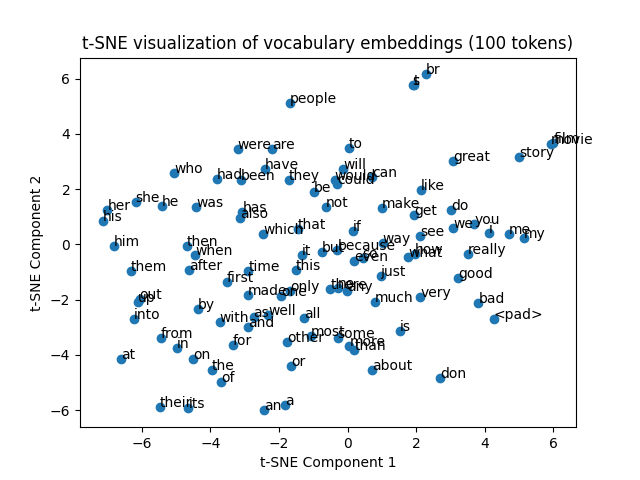

In [21]:
# Plot embeddings of first 100 words using t-SNE
nextplot()
_ = tsne_vocab(glove_embeddings, torch.arange(100), vocab)

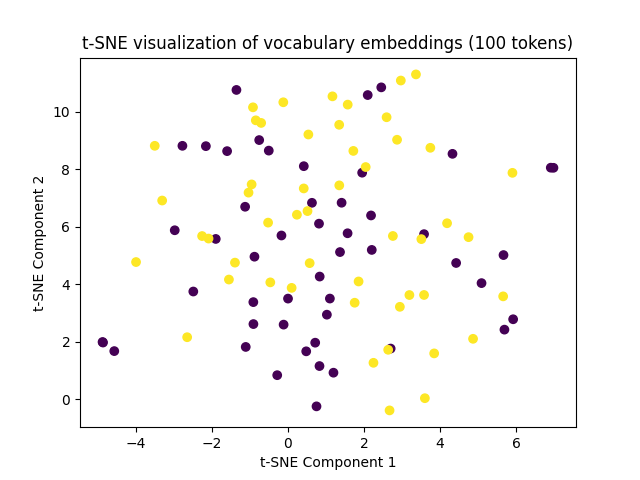

In [22]:
# You can also specify colors and/or drop the item labels
nextplot()
_ = tsne_vocab(glove_embeddings, torch.arange(100), colors=[0] * 50 + [1] * 50)

### Adding PCA

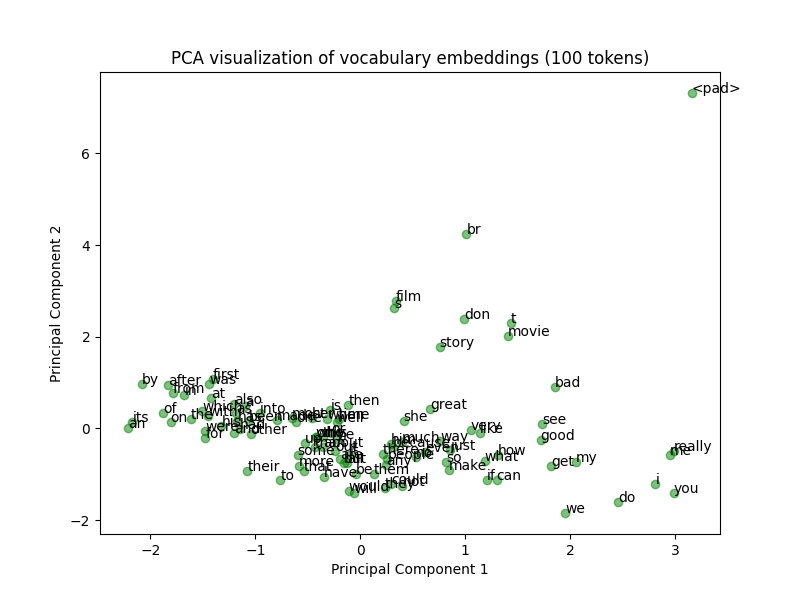

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def PCA_embeddings(embeddings, tokens=None, vocab=None, colors=None, n_components=2):
    """
    Visualize embeddings from an embedding module using PCA.
    
    Args:
        embeddings: embedding layer of the model
        tokens: limit to the provided embeddings (a tensor of indexes)
        vocab: a vocabulary to label dots in scatter plot with tokens
        colors: colors for each point in the scatter plot
        n_components: number of principal components to use for PCA
    """
    # Convert embeddings to numpy array
    embedding_matrix = embeddings.weight.data.numpy()[:100]
    if tokens is not None:
        embedding_matrix = embedding_matrix[tokens]
    else:
        tokens = torch.arange(len(embedding_matrix))

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(embedding_matrix)

    # Plot PCA result
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.5)

    # Add token labels to points
    if vocab:
        for i in range(len(embedding_matrix)):
            plt.annotate(vocab.get_itos()[tokens[i]], (principal_components[i, 0], principal_components[i, 1]))

    plt.title(f'PCA visualization of vocabulary embeddings (100 tokens)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


PCA_embeddings(glove_embeddings, vocab=vocab, colors="green")

### Task 4c

In [24]:
# hyperparameter settings for rest of task 4
vocab_size = len(dataset.vocab)
embedding_dim = 100
hidden_dim = 100
num_layers = 2
n_epochs = 10
cell_dropout = 0.0

In [25]:
# train a plain model
model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_dropout).to(
    DEVICE
)
reviews_train(model, train_loader, val_loader, epochs=n_epochs)

# Should reach a (train) accuracy of >0.9. If not, rerun.

Epoch  1	train accuracy: 0.4928	train loss: 0.6999
            val accuracy: 0.4825	val loss: 0.6957
Epoch  2	train accuracy: 0.4925	train loss: 0.6938
            val accuracy: 0.4800	val loss: 0.6934
Epoch  3	train accuracy: 0.5097	train loss: 0.6930
            val accuracy: 0.4800	val loss: 0.6940
Epoch  4	train accuracy: 0.5109	train loss: 0.6916
            val accuracy: 0.4900	val loss: 0.6964
Epoch  5	train accuracy: 0.5828	train loss: 0.6606
            val accuracy: 0.4875	val loss: 0.7749
Epoch  6	train accuracy: 0.6456	train loss: 0.5660
            val accuracy: 0.4875	val loss: 0.7711
Epoch  7	train accuracy: 0.7550	train loss: 0.4504
            val accuracy: 0.6075	val loss: 0.8564
Epoch  8	train accuracy: 0.8856	train loss: 0.2771
            val accuracy: 0.6675	val loss: 0.7893
Epoch  9	train accuracy: 0.9481	train loss: 0.1452
            val accuracy: 0.6800	val loss: 0.9553
Epoch 10	train accuracy: 0.9766	train loss: 0.0695
            val accuracy: 0.6725	val los

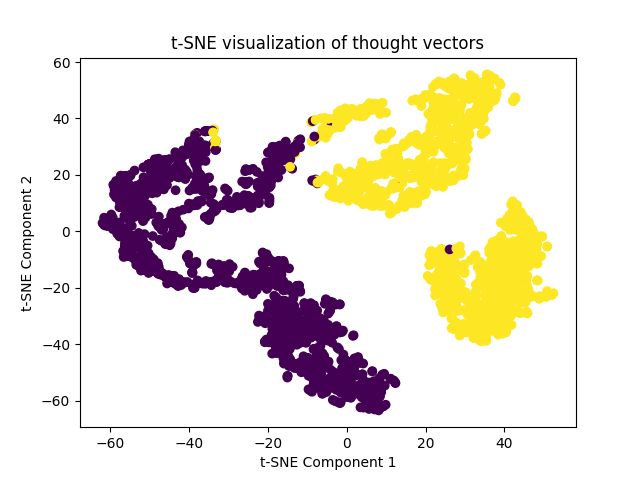

In [26]:
# Plot t-SNE embeddings of the thought vectors for training data
# point color = label
nextplot()
_ = tsne_thought(model, train_loader, DEVICE)

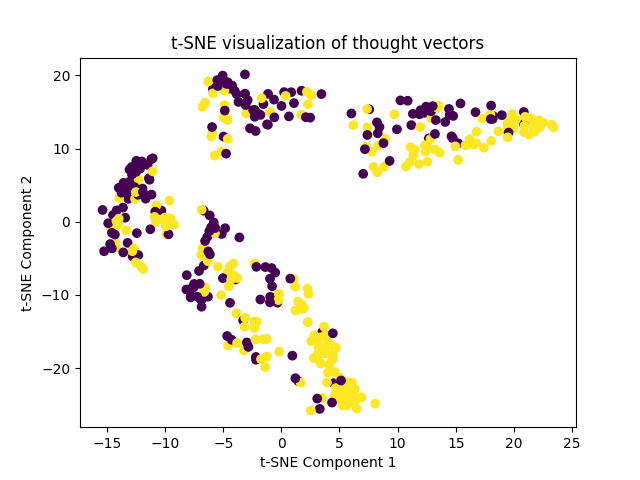

In [27]:
# Plot t-SNE embeddings of of the thought vectors for validation data
nextplot()
_ = tsne_thought(model, val_loader, DEVICE)

### Task 4d

In [28]:
# Initialize the model with *p*re-trained embeddings with *f*inetuning, then train
model_pf = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_dropout)
reviews_load_embeddings(model_pf.embedding, vocab.get_stoi())
reviews_train(model_pf, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4888	train loss: 0.6950
            val accuracy: 0.4850	val loss: 0.6932
Epoch  2	train accuracy: 0.5153	train loss: 0.6905
            val accuracy: 0.5200	val loss: 0.6928
Epoch  3	train accuracy: 0.5131	train loss: 0.6928
            val accuracy: 0.4775	val loss: 0.6932
Epoch  4	train accuracy: 0.5353	train loss: 0.6840
            val accuracy: 0.4850	val loss: 0.7001
Epoch  5	train accuracy: 0.6828	train loss: 0.5607
            val accuracy: 0.7925	val loss: 0.5257
Epoch  6	train accuracy: 0.9131	train loss: 0.2397
            val accuracy: 0.8300	val loss: 0.4950
Epoch  7	train accuracy: 0.9812	train loss: 0.0594
            val accuracy: 0.7800	val loss: 0.9693
Epoch  8	train accuracy: 0.9966	train loss: 0.0134
            val accuracy: 0.8225	val loss: 0.8521
Epoch  9	train accuracy: 0.9984	train loss: 0.0061
            val accuracy: 0.8150	val 

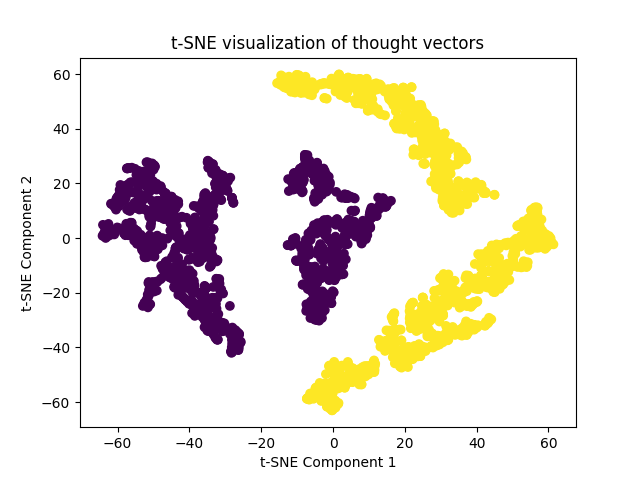

In [29]:
nextplot()
_ = tsne_thought(model_pf, train_loader, DEVICE)

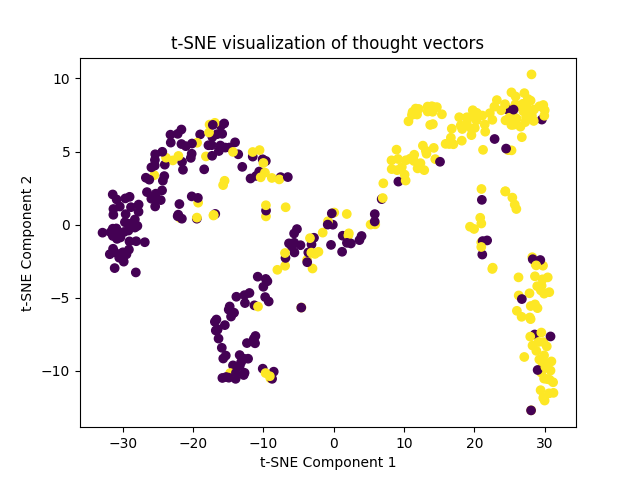

In [30]:
nextplot()
_ = tsne_thought(model_pf, val_loader, DEVICE)

### Task 4e

In [31]:
# Initialize the model with *p*re-trained embeddings without finetuning, then train
model_p = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, cell_dropout)
reviews_load_embeddings(model_p.embedding, vocab.get_stoi())
model_p.embedding.weight.requires_grad = False
reviews_train(model_p, train_loader, val_loader, epochs=n_epochs)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5059	train loss: 0.6942
            val accuracy: 0.5200	val loss: 0.6923
Epoch  2	train accuracy: 0.5091	train loss: 0.6937
            val accuracy: 0.4775	val loss: 0.6938
Epoch  3	train accuracy: 0.5272	train loss: 0.6897
            val accuracy: 0.4825	val loss: 0.7041
Epoch  4	train accuracy: 0.5416	train loss: 0.6838
            val accuracy: 0.4700	val loss: 0.6982
Epoch  5	train accuracy: 0.6766	train loss: 0.6063
            val accuracy: 0.5950	val loss: 0.6496
Epoch  6	train accuracy: 0.7275	train loss: 0.5728
            val accuracy: 0.6250	val loss: 0.6169
Epoch  7	train accuracy: 0.7953	train loss: 0.4760
            val accuracy: 0.7700	val loss: 0.5227
Epoch  8	train accuracy: 0.8284	train loss: 0.4112
            val accuracy: 0.7700	val loss: 0.5793
Epoch  9	train accuracy: 0.8484	train loss: 0.3707
            val accuracy: 0.7175	val 

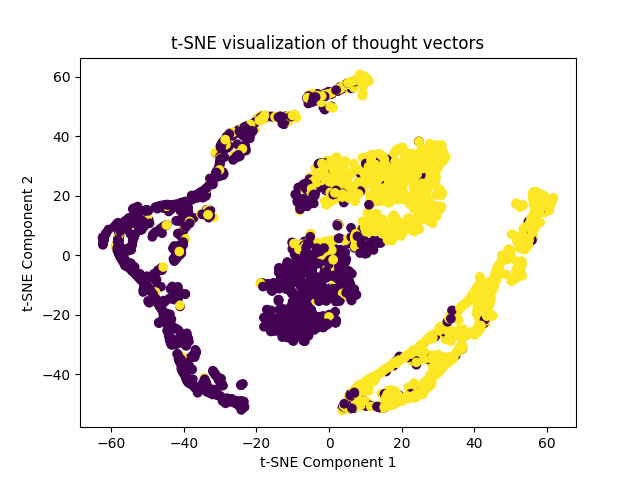

In [32]:
nextplot()
_ = tsne_thought(model_p, train_loader, DEVICE)

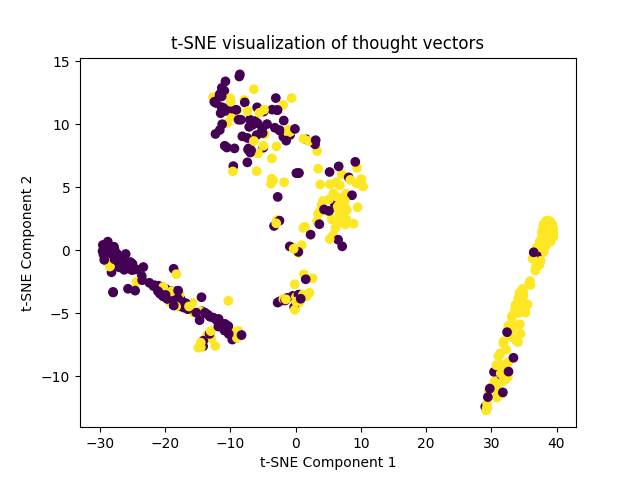

In [33]:
nextplot()
_ = tsne_thought(model_p, val_loader, DEVICE)

## Task 5: Exploration

### Task 5a

#### Simple RNN class implementation

In [34]:
# YOUR CODE HERE
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, cell_dropout=0.0, bidirectional=False, cell_type='lstm'):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.cell_type = cell_type

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=cell_dropout, batch_first=True, bidirectional=bidirectional)
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, dropout=cell_dropout, batch_first=True, bidirectional=bidirectional)
        else:  # Elman
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, dropout=cell_dropout, batch_first=True, bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        hidden = self.init_hidden(len(x))

        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded, hidden)
        last_output = rnn_out[:, -1, :]

        logits = self.fc(last_output)
        prob = self.sigmoid(logits)

        return prob, last_output

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if self.cell_type == 'lstm':
            hidden = (
                weight.new(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_dim).zero_().to(DEVICE),
                weight.new(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_dim).zero_().to(DEVICE)
            )
        else:  # Elman RNN and GRU
            hidden = weight.new(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_dim).zero_().to(DEVICE)
        return hidden

### Train and evaluate the model

Simple RNN is trained and evaluated with the all possible combinations of the following parameters:
- __Dropout__: 0, 0.8
- __RNN cell types__: Elman cell, GRU cell, LSTM cell 
- __Direction of RNN__ : unidirectional, bidirectional.

In [33]:
# Dropout values
dropout_values = [0, 0.8]

# Cell types
cell_types = ['rnn', 'gru', 'lstm']

# Bidirectional values
bidirectional_values = [False, True]

for dropout in dropout_values:
    for cell_type in cell_types:
        for bidirectional in bidirectional_values:
            print(f"Training model with dropout={dropout}, cell_type={cell_type}, bidirectional={str(bidirectional)}")
            model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout, bidirectional, cell_type)
            reviews_load_embeddings(model.embedding, vocab.get_stoi())
            reviews_train(model, train_loader, val_loader, epochs=n_epochs)

Training model with dropout=0, cell_type=rnn, bidirectional=False
Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5009	train loss: 0.7070
            val accuracy: 0.4900	val loss: 0.6977
Epoch  2	train accuracy: 0.5103	train loss: 0.7074
            val accuracy: 0.5225	val loss: 0.7022
Epoch  3	train accuracy: 0.5169	train loss: 0.7050
            val accuracy: 0.5175	val loss: 0.7030
Epoch  4	train accuracy: 0.5487	train loss: 0.6772
            val accuracy: 0.5300	val loss: 0.7158
Epoch  5	train accuracy: 0.6028	train loss: 0.6299
            val accuracy: 0.4775	val loss: 0.7776
Epoch  6	train accuracy: 0.6278	train loss: 0.5906
            val accuracy: 0.5075	val loss: 0.7360
Epoch  7	train accuracy: 0.6494	train loss: 0.5582
            val accuracy: 0.5400	val loss: 0.7344
Epoch  8	train accuracy: 0.6434	train loss: 0.5669
            val accuracy: 0.5425	val loss: 0.8228
Epoch  9	train accurac

Simple RNN is trained and evaluated with the all possible combinations of the following parameters:
- __Dropout__: 0.4
- __RNN cell types__: Elman cell, GRU cell, LSTM cell 
- __Direction of RNN__ : unidirectional, bidirectional.

In [126]:
# Dropout values
dropout_values = [0.4]

# Cell types
cell_types = ['rnn', 'gru', 'lstm']

# Bidirectional values
bidirectional_values = [False, True]

for dropout in dropout_values:
    for cell_type in cell_types:
        for bidirectional in bidirectional_values:
            print(f"Training model with dropout={dropout}, cell_type={cell_type}, bidirectional={str(bidirectional)}")
            model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout, bidirectional, cell_type)
            reviews_load_embeddings(model.embedding, vocab.get_stoi())
            reviews_train(model, train_loader, val_loader, epochs=n_epochs)

Training model with dropout=0.4, cell_type=rnn, bidirectional=False
Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.4884	train loss: 0.7157
            val accuracy: 0.5175	val loss: 0.6949
Epoch  2	train accuracy: 0.5044	train loss: 0.7055
            val accuracy: 0.4850	val loss: 0.7427
Epoch  3	train accuracy: 0.5044	train loss: 0.7066
            val accuracy: 0.5200	val loss: 0.6956
Epoch  4	train accuracy: 0.5012	train loss: 0.7095
            val accuracy: 0.4900	val loss: 0.6954
Epoch  5	train accuracy: 0.5269	train loss: 0.6979
            val accuracy: 0.5200	val loss: 0.7268
Epoch  6	train accuracy: 0.5875	train loss: 0.6570
            val accuracy: 0.5000	val loss: 0.7310
Epoch  7	train accuracy: 0.6378	train loss: 0.5750
            val accuracy: 0.5475	val loss: 0.8477
Epoch  8	train accuracy: 0.6663	train loss: 0.5276
            val accuracy: 0.5450	val loss: 0.7639
Epoch  9	train accur

### Task 5b

According to our research, the model with the highest performance (val accuracy: 0.9050, val loss: 0.2916) has the following parameters:

- __Dropout__: 0.4
- __RNN cell type__: GRU cell
- __Direction of RNN__ : unidirectional

P.s. the highest performance has been reached on the 2nd Epoch of training process.

### Optimization of the best model

Here we fix aforementioned parameters of the model and try to discover the best set of hyper parameters for it

In [135]:
# hyperparameter settings 
hidden_dims = [50, 100]
num_layers_values = [1, 2]
n_epochs_values = [5]

for hidden_dim in hidden_dims:
    for num_layers in num_layers_values:
        for n_epochs in n_epochs_values:
            print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}, n_epochs={n_epochs}")
            model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, num_layers, 0.4, False, 'gru')
            reviews_load_embeddings(model.embedding, vocab.get_stoi())
            reviews_train(model, train_loader, val_loader, epochs=n_epochs)

Training model with hidden_dim=50, num_layers=1, n_epochs=5
Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.6428	train loss: 0.6044
            val accuracy: 0.8550	val loss: 0.3222
Epoch  2	train accuracy: 0.9519	train loss: 0.1377
            val accuracy: 0.8775	val loss: 0.3597
Epoch  3	train accuracy: 0.9981	train loss: 0.0090
            val accuracy: 0.8700	val loss: 0.5382
Epoch  4	train accuracy: 1.0000	train loss: 0.0016
            val accuracy: 0.8775	val loss: 0.5922
Epoch  5	train accuracy: 1.0000	train loss: 0.0008
            val accuracy: 0.8800	val loss: 0.6587
Training model with hidden_dim=50, num_layers=2, n_epochs=5
Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5837	train loss: 0.6547
            val accuracy: 0.8300	val loss: 0.4110
Epoch  2	train accuracy: 0.9203	train loss: 0.2124
            val

#### Visualization of Model's Validation Accuracy and Loss Based on the Epoch Hyperparameter

These visualizations reveal that the model achieves its peak validation accuracy and minimum validation loss during the second Epoch.

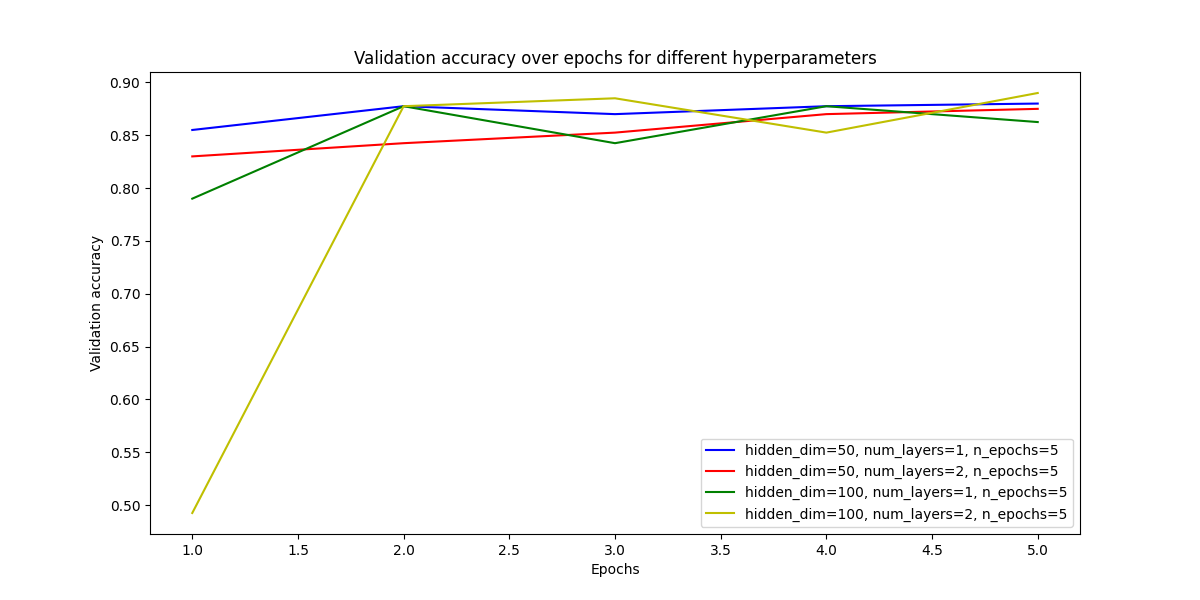

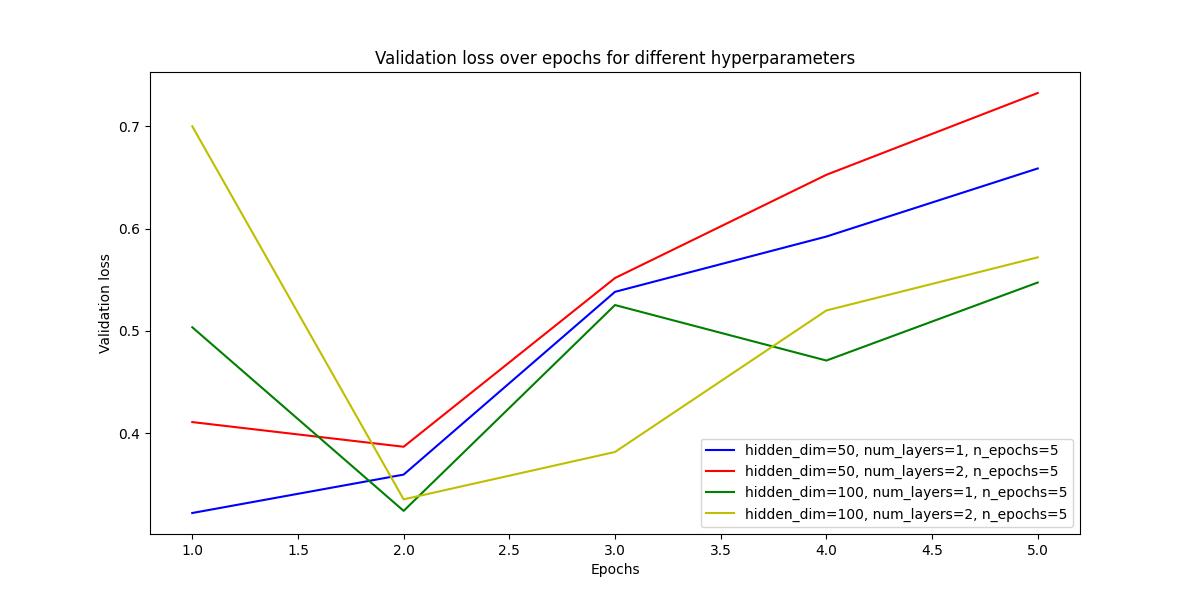

In [35]:
import matplotlib.pyplot as plt

# lists are returned from training function
# For simplicity, let's only consider validation accuracy here
val_accuracies_50_1_5 = [0.8550, 0.8775, 0.8700, 0.8775, 0.8800]
val_accuracies_50_2_5 = [0.8300, 0.8425, 0.8525, 0.8700, 0.8750]
val_accuracies_100_1_5 = [0.7900, 0.8775, 0.8425, 0.8775, 0.8625]
val_accuracies_100_2_5 = [0.4925, 0.8775, 0.8850, 0.8525, 0.8900]
epochs = range(1, len(val_accuracies_50_1_5) + 1)

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies_50_1_5, 'b', label='hidden_dim=50, num_layers=1, n_epochs=5')
plt.plot(epochs, val_accuracies_50_2_5, 'r', label='hidden_dim=50, num_layers=2, n_epochs=5')
plt.plot(epochs, val_accuracies_100_1_5, 'g', label='hidden_dim=100, num_layers=1, n_epochs=5')
plt.plot(epochs, val_accuracies_100_2_5, 'y', label='hidden_dim=100, num_layers=2, n_epochs=5')
plt.title('Validation accuracy over epochs for different hyperparameters')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

# lists are returned from training function
val_losses_50_1_5 = [0.3222, 0.3597, 0.5382, 0.5922, 0.6587]
val_losses_50_2_5 = [0.4110, 0.3869, 0.5517, 0.6525, 0.7324]
val_losses_100_1_5 = [0.5036, 0.3243, 0.5253, 0.4711, 0.5473]
val_losses_100_2_5 = [0.6999, 0.3355, 0.3818, 0.5200, 0.5719]

# Plot validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_losses_50_1_5, 'b', label='hidden_dim=50, num_layers=1, n_epochs=5')
plt.plot(epochs, val_losses_50_2_5, 'r', label='hidden_dim=50, num_layers=2, n_epochs=5')
plt.plot(epochs, val_losses_100_1_5, 'g', label='hidden_dim=100, num_layers=1, n_epochs=5')
plt.plot(epochs, val_losses_100_2_5, 'y', label='hidden_dim=100, num_layers=2, n_epochs=5')
plt.title('Validation loss over epochs for different hyperparameters')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

#### Visualization of Model's Validation Accuracy and Loss from the Second Epoch (Peak Performance)

The plot reveals two optimal sets of hyperparameters::
1. hidden_dim=100, num_layers=1: accuracy = 0.8775, loss = 0.3243
2. hidden_dim=100, num_layers=2: accuracy = 0.8775, loss = 0.3355

Given that the accuracy for both sets is identical, and the loss values are only marginally different, we need to consider other factors. We have a moderate n_epoch=2 value and a relatively high dropout=0.4 parameter, which introduces a higher level of regularization. Taking these into account, **we opt for the second set of hyperparameters (hidden_dim=100, num_layers=2)**. This choice enables the second layer of GRUs to detect more complex data patterns, counterbalancing the level of regularization introduced by the n_epoch and dropout hyperparameters.

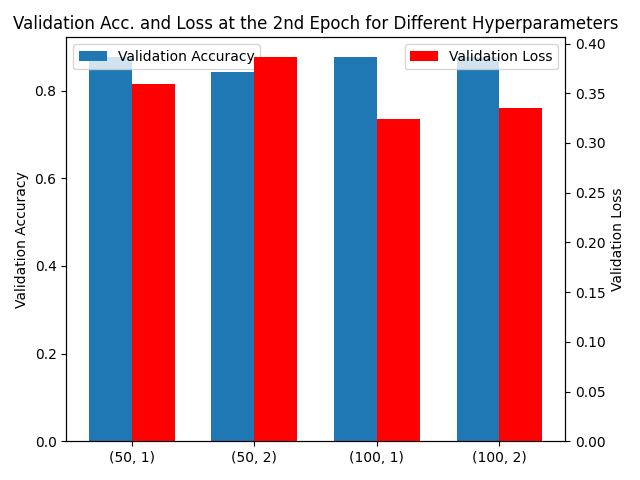

In [36]:
import numpy as np

# Validation accuracy and loss at the second epoch for different hyperparameters
val_accuracies = [0.8775, 0.8425, 0.8775, 0.8775]
val_losses = [0.3597, 0.3869, 0.3243, 0.3355]
labels = ['(50, 1)', '(50, 2)', '(100, 1)', '(100, 2)']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots()

# Plot validation accuracy
rects1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Acc. and Loss at the 2nd Epoch for Different Hyperparameters')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# Plot validation loss
rects2 = ax2.bar(x + width/2, val_losses, width, label='Validation Loss', color='r')
ax2.set_ylabel('Validation Loss')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()

### Evaluation of the optimized model

In [155]:
# Best hyperparameters
hidden_dim = 100
num_layers = 2
n_epochs = 2
dropout = 0.4
bidirectional = False
cell_type = 'gru'

print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}, n_epochs={n_epochs}")
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout, bidirectional, cell_type)
reviews_load_embeddings(model.embedding, vocab.get_stoi())
reviews_train(model, train_loader, val_loader, epochs=n_epochs)

reviews_eval(model, test_loader, label="test")

Training model with hidden_dim=100, num_layers=2, n_epochs=2
Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Epoch  1	train accuracy: 0.5900	train loss: 0.6332
            val accuracy: 0.8175	val loss: 0.4341
Epoch  2	train accuracy: 0.9353	train loss: 0.1697
            val accuracy: 0.8625	val loss: 0.3648
            test accuracy: 0.9025	test loss: 0.2814
